In [1]:
import pandas as pd
import numpy as np

from darts.models import RNNModel, BlockRNNModel
from darts import TimeSeries

from datetime import datetime
import matplotlib.pyplot as plt
import torch

train_new = False

/home/kpanthi/.conda/envs/cenv/lib/python3.10/site-packages/statsforecast/core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
/home/kpanthi/.conda/envs/cenv/lib/python3.10/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


In [2]:
df = pd.read_csv('../dataset/chattahoochee_1hr_02336490.csv')

In [3]:
dates = pd.date_range(start=df['DATE'][0], periods=df['DATE'].shape[0], freq='1h')

In [4]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()

columns = df.columns.tolist()
for col in columns:
  if col != 'DATE':
    df[col] = min_max_scaler.fit_transform(df[col].values.reshape(-1,1))


target_series = TimeSeries.from_times_and_values(dates, df['gaze_height'])
precip = TimeSeries.from_times_and_values(dates, df['Precip'])
wbt = TimeSeries.from_times_and_values(dates, df['WetBulbTemp'])
dbt = TimeSeries.from_times_and_values(dates, df['DryBulbTemp'])
rh = TimeSeries.from_times_and_values(dates, df['RelHumidity'])
ws = TimeSeries.from_times_and_values(dates, df['WindSpeed'])
sp = TimeSeries.from_times_and_values(dates, df['Stationpressure'])


In [5]:
df.columns.tolist()

['DryBulbTemp',
 'Precip',
 'RelHumidity',
 'Stationpressure',
 'WetBulbTemp',
 'WindSpeed',
 'gaze_height',
 'DATE']

In [6]:
dataset_n = '_1hr_chattachoochee_full_gaze_height'
LSTM = 'LSTM'+dataset_n
BlockLSTM = 'BlockLSTM'+dataset_n

In [7]:
from darts import concatenate
all_covars = [dbt, wbt, precip, rh, ws, sp]
past_cov = concatenate([wbt, precip, rh, ws, sp], axis=1)

In [8]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

# optimizer parameters
optimizer_kwargs = {
    "lr": 1e-3,
}

# early stopping parameters
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=1e-5,
    mode="min"
)

# PyTorch Lightning Trainer parameters
pl_trainer_kwargs = {
    "gradient_clip_val": 1,
    "accelerator": "gpu",
    "callbacks": [early_stopping],
    "max_epochs": 200
}

# learning rate scheduler class and parameters
lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
lr_scheduler_kwargs = {
    "gamma": 0.999, # rate at which lr decays
}

# Common model parameters
common_model_args = {
    "model": "LSTM",
    "input_chunk_length": 13,
    "training_length": 13,
    "optimizer_kwargs": optimizer_kwargs,
    "pl_trainer_kwargs": pl_trainer_kwargs,
    "lr_scheduler_cls": lr_scheduler_cls,
    "lr_scheduler_kwargs": lr_scheduler_kwargs,
    "likelihood": None,
    "save_checkpoints": True,
    "force_reset": True,
    "batch_size": 512,
    "random_state": 42, # seed to generate random numbers
    "dropout": 0.3
}

In [9]:
models = {
    LSTM: RNNModel,
    #BlockLSTM: BlockRNNModel
}

#train: val: test = 6:1:3
target_train, temp = target_series.split_after(0.6)
val, test = temp.split_after(0.25)

cov_train, cov_temp = past_cov.split_after(0.6)
cov_val, cov_test = cov_temp.split_after(0.25)

In [10]:
import time
t1 = time.time()

for name, model in models.items():

    early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=5,
        min_delta=1e-5,
        mode="min"
    )

    pl_trainer_kwargs["callbacks"] = [early_stopping]

    
    if train_new:
        
        if name == LSTM:
          model = model(
                  **common_model_args,
                  hidden_dim=128,
                  model_name=LSTM
              )
    
        if name == LSTM:
            model.fit(
                series=target_train,
                val_series=val,
                verbose=False,
            )

    # load from checkpoint returns a new model object, we store it in the models dict
    models[name] = model.load_from_checkpoint(name)

print((time.time() - t1))

0.9030699729919434


/home/kpanthi/.conda/envs/cenv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [11]:
#Define custom metrics (obtained from Leon + Rishav paper)

epsilon = np.finfo(float).eps

def Wape(y, y_pred):
    """Weighted Average Percentage Error metric in the interval [0; 100]"""
    nominator = np.sum(np.abs(np.subtract(y, y_pred)))
    denominator = np.add(np.sum(np.abs(y)), epsilon)
    wape = np.divide(nominator, denominator)*100.0
    return wape

def nse(y, y_pred):
    return (1-(np.sum((y_pred-y)**2)/np.sum((y-np.mean(y))**2)))

In [21]:
from darts.metrics import rmse
from darts.metrics.metrics import _get_values_or_raise
import sys

def saveData(test, y, y_pred, model_name, hrs):
    start_time = test.start_time()  
    end_time = test.end_time()     
    time_index = pd.date_range(start=start_time, end=end_time, freq='H')
    
    if len(y) != len(time_index):
        raise ValueError(f"Length of y ({len(y)}) does not match number of time steps ({len(time_index)}).")
    if len(y_pred) != len(time_index):
        raise ValueError(f"Length of y_pred ({len(y_pred)}) does not match number of time steps ({len(time_index)}).")
    df = pd.DataFrame({
        'y': y,
        'y_pred': y_pred
    }, index=time_index)
    
    df = df.reset_index().rename(columns={'index': 'DATE'})
    df.to_csv(f'results/{model_name}_predictions_{hrs}.csv')
    

def eval_model(model, name, horizon, past_covariates=None, future_covariates=None):

    with open('model_evaluation_results_lstm.txt', 'a') as f:

      backtest = model.historical_forecasts(series=test,
                                            past_covariates=past_covariates,
                                            future_covariates=future_covariates,
                                            retrain=False,
                                            verbose=False,
                                            forecast_horizon=horizon)
      print(backtest)
      print(test.start_time(), backtest.start_time(), test.end_time(), backtest.end_time())
      start_time = test.start_time() #pandas timestamp
      end_time = test.end_time()
      y, y_pred = _get_values_or_raise(target_series, backtest, intersect=True)
      #saveData(backtest, y, y_pred, 'lstm', horizon)
      plotResults(y_pred, y, 'LSTM')
      #plot_results_to_gif(y_pred, y, 'LSTM')
      original_stdout = sys.stdout
      sys.stdout = f
      print('Name: ', name)
      print('Horizon: ', horizon)
      print('Wape = ', Wape(y, y_pred))
      print('NSE = ', nse(y, y_pred))
      print('Backtest RMSE = {}'.format(rmse(target_series, backtest)))
      print('\n')
      sys.stdout = original_stdout
      print('Name: ', name)
      print('Horizon: ', horizon)
      print('Wape = ', Wape(y, y_pred))
      print('NSE = ', nse(y, y_pred))
      print('Backtest RMSE = {}'.format(rmse(target_series, backtest)))
      target_series[-len(backtest)-100:].plot()
      backtest.plot(label=name)
      print('\n\n')




GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/kpanthi/.conda/envs/cenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


<TimeSeries (DataArray) (time: 9403, component: 1, sample: 1)>
array([[[0.32229309]],

       [[0.32631575]],

       [[0.32544513]],

       ...,

       [[0.18549468]],

       [[0.1824011 ]],

       [[0.17900398]]])
Coordinates:
  * time       (time) datetime64[ns] 2023-04-03T11:00:00 ... 2024-04-29T05:00:00
  * component  (component) object '0'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
2023-04-02 20:00:00 2023-04-03 11:00:00 2024-04-29 05:00:00 2024-04-29 05:00:00


/local_scratch/slurm.846638/ipykernel_3395854/3637844780.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = pandas.date_range(start=start_date, end=end_date, freq='H')
/local_scratch/slurm.846638/ipykernel_3395854/3637844780.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Name:  LSTM_1hr_chattachoochee_full_gaze_height
Horizon:  3
Wape =  12.595519751341635
NSE =  0.9305168047222743
Backtest RMSE = 0.026850799632997174





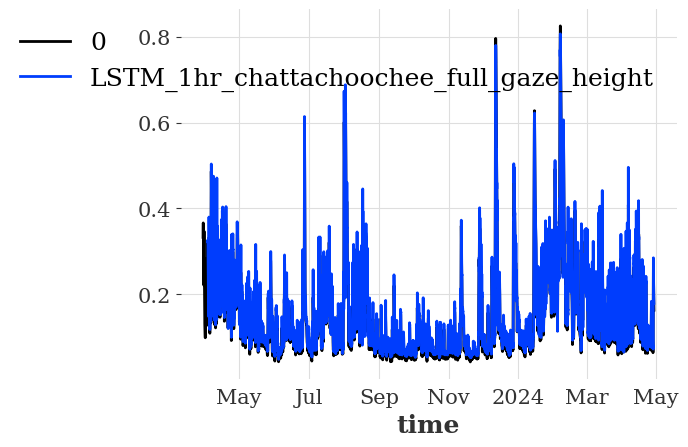

In [26]:
for model_name, model in models.items():
    for horizon in [3]:
        if model_name == BlockLSTM:
            eval_model(model, model_name, horizon, cov_test)
        if model_name == LSTM:
            eval_model(model, model_name, horizon)

In [25]:
def plotResults(predss, truess, model_name, start_date='2023-01-01 00:00', end_date = '2023-12-31 23:00'):
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
    import pandas
    import matplotlib.font_manager as fm

    # Set the font to Times New Roman
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 18  # Increase base font size
    plt.rcParams['font.weight'] = 'normal'

    time_index = pandas.date_range(start=start_date, end=end_date, freq='H')
    # Adjust the time index to match the length of the data
    min_len = min(len(time_index), len(predss))
    time_index = time_index[:min_len]
    #truess = np.roll(truess, 6)
    predss = predss[:min_len]
    truess = truess[:min_len]
    wapee = Wape(truess, predss)
    nsee = nse(truess, predss)
    # Plotting
    fig, ax = plt.subplots(figsize=(14, 7))  # Increased figure size
    plt.grid(False)
    ax.plot(time_index, predss, label='{0} Predictions'.format(model_name), color='blue', linewidth=2)
    ax.plot(time_index, truess, label='Observed height', color='#BB0000', linewidth=2)
    ax.plot([], [], ' ', label=f"NSE: {round(nsee,4)}")
    ax.plot([], [], ' ', label=f"WAPE: {round(wapee,2)}")
    ax.set_xlabel('Time', fontsize=18, fontdict=dict(weight='normal'))
    ax.set_ylabel('River Level', fontsize=18, fontdict=dict(weight='normal'))
    ax.set_ylim(0, 2)
    ax.legend(loc='upper left', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)

    axins1 = inset_axes(ax, width="60%", height="40%", loc='upper right')
    axins1.plot(time_index, predss, color='blue', linewidth=1.5)
    axins1.plot(time_index, truess, color='#BB0000', linewidth=1.5)
    axins1.set_xlabel('Time', fontsize=14, fontdict=dict(weight='normal'))
    axins1.set_ylabel('River Level', fontsize=14, fontdict=dict(weight='normal'))
    axins1.tick_params(axis='both', which='major', labelsize=16)
    axins1.spines['left'].set_visible(True)
    axins1.spines['bottom'].set_visible(True)
    axins1.spines['top'].set_visible(True)
    axins1.spines['right'].set_visible(True)
    axins1.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    axins1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    axins1.set_ylim(0,1)
    start_date = pandas.Timestamp('2023-05-01 03:00')  # Adjust date to match the dataset
    end_date = pandas.Timestamp('2023-06-01 23:00')  # Adjust date to match the dataset
    axins1.set_xlim(start_date, end_date)

    # Apply mark_inset to show the bounds of the inset on the main plot
    mark_inset(ax, axins1, loc1=3, loc2=4, fc="none", ec="0.25")
    plt.grid(False)
    plt.tight_layout()

    # Save the figure with higher DPI for better quality
    plt.savefig('LstmResults.png', dpi=300)
    plt.close(fig)
    plt.show()

In [13]:
target_train, temp = target_series.split_after(0.9)
val, test = temp.split_after(0.25)
total = len(df[df['DATE'] >= '2023-01-01 00:00'])
test = test[-total:]

In [32]:
import datetime
from typing import Tuple

def find_missing_dates(df: pd.DataFrame, date_col: str = 'DATE', 
                       threshold: datetime.timedelta = datetime.timedelta(minutes=15)) -> Tuple[datetime.timedelta, datetime.timedelta]:
    """
    Find gaps in the date column of a DataFrame.
    
    Args:
    df (pd.DataFrame): Input DataFrame.
    date_col (str): Name of the date column.
    threshold (datetime.timedelta): Threshold for considering a gap.
    
    Returns:
    Tuple[datetime.timedelta, datetime.timedelta]: Maximum gap and total gap.
    """
    df[date_col] = pd.to_datetime(df[date_col])
    prev = df[date_col].iloc[0]
    total_gap = datetime.timedelta(minutes=0)
    max_diff = threshold

    for d in df[date_col].iloc[1:]:
        diff = d - prev
        if diff > max_diff:
            max_diff = diff
        if diff > threshold:
            total_gap += diff
            print(f"Gap found between {prev} and {d}")
        prev = d

    print(f'Max gap: {max_diff}')
    print(f'Total gap: {total_gap}')
    return max_diff, total_gap

find_missing_dates(df, 'DATE', datetime.timedelta(hours=1))

Max gap: 1:00:00
Total gap: 0:00:00


(datetime.timedelta(seconds=3600), datetime.timedelta(0))

In [29]:
df

,DATE,gauge_heights,DryBulbTemp,Precip,RelHumidity,Stationpressure,WetBulbTemp,WindSpeed
0,2008-01-01 00:00:00,0.117442,0.329897,0.0,0.844444,0.594937,0.415584,0.000000
1,2008-01-01 01:00:00,0.113750,0.329897,0.0,0.877778,0.588608,0.428571,0.000000
2,2008-01-01 02:00:00,0.109659,0.340206,0.0,0.877778,0.582278,0.441558,0.135135
3,2008-01-01 03:00:00,0.106266,0.350515,0.0,0.844444,0.582278,0.441558,0.135135
4,2008-01-01 04:00:00,0.102475,0.350515,0.0,0.844444,0.588608,0.441558,0.162162
...,...,...,...,...,...,...,...,...
143807,2024-05-27 23:00:00,0.176512,0.690722,0.0,0.766667,0.506329,0.831169,0.081081
143808,2024-05-28 00:00:00,0.170724,0.670103,0.0,0.855556,0.512658,0.831169,0.000000
143809,2024-05-28 01:00:00,0.166334,0.649485,0.0,0.888889,0.518987,0.818182,0.000000
143810,2024-05-28 02:00:00,0.162542,0.649485,0.0,0.922222,0.512658,0.831169,0.000000
